In [42]:
import os
import sys
import dcor
import pandas as pd
import warnings
from sklearn.model_selection import train_test_split

from dowhy import CausalModel

root_path = root_path = os.path.realpath('../..')
try:
    import auto_causality
except ModuleNotFoundError:
    sys.path.append(os.path.join(root_path, "auto-causality"))

from auto_causality import AutoCausality
from auto_causality.data_utils import preprocess_dataset
from auto_causality.scoring import Scorer
from auto_causality.datasets import iv_dgp_econml
from auto_causality.params import SimpleParamService

warnings.filterwarnings("ignore")

### Model fitting & scoring

Here we fit a (selection of) model(s) to the data and score them with the energy distance score on held-out data.

We create a synthetic dataset and pre-process it with a DGP described [here](https://github.com/microsoft/EconML/blob/main/notebooks/OrthoIV%20and%20DRIV%20Examples.ipynb). The dataset size, number of features and constant true effect, can be varied.

In [54]:
TE = 11.50
data = iv_dgp_econml(n=5000, p=15, true_effect=TE)

treatment = data.treatment
targets = data.outcomes
instruments = data.instruments
data_df, features_X, features_W = preprocess_dataset(
    data.data, treatment, targets, instruments
)

outcome = targets[0]
train_df, test_df = train_test_split(data_df, test_size=0.2)
Xtest = test_df[features_X]
train_df.head()

,treatment,y,Z,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,random
3883,0.0,8.197749,0.0,-0.108759,0.312199,0.145267,1.461314,-0.331638,0.245148,-1.420419,1.653674,0.968073,0.216494,-0.773523,1.168210,-1.303207,0.981035,-0.738480,1.0
2883,0.0,13.708753,0.0,0.116328,-0.429633,0.737191,0.357166,-0.329686,1.165845,-0.132494,0.730496,0.257616,1.983186,0.664017,0.554632,-0.348515,-0.865764,1.039719,0.0
1678,1.0,16.849497,1.0,0.033532,1.965616,-0.723270,-0.442394,1.255850,-0.086034,-0.665238,1.229994,-1.475536,0.510722,-0.669037,-0.393076,-0.428835,-0.308246,-0.731096,0.0
4309,1.0,21.590414,1.0,-0.861365,-2.260376,-1.925975,0.558850,-1.193709,-0.496094,-0.529655,-1.257560,1.858634,-0.642740,0.242831,2.040759,-1.663952,-0.719226,-1.315239,1.0
1552,0.0,11.009199,0.0,0.486737,0.266549,0.165638,0.861002,1.349509,0.749226,0.493792,0.322053,-0.243507,-0.465008,-0.732464,1.158468,0.102736,-0.438340,0.727275,0.0


If you want to use specific estimators, pass these as a list to `estimator_list` param in `AutoCausality`. IV estimators are listed in `all_estimators` below.

The other allowed values are `all` and `auto`, the default is `auto`.

For IV models, currently specify `auto` for propensity model, and instruments when

Fitting the model is as simple as calling AutoCausality.fit(), with the only required parameter apart from the data being the `instruments` for IV models.



In [55]:
estimator_list = ["DMLIV"] #, "OrthoIV", "LinearDRIV", "SparseLinearDRIV", "LinearIntentToTreatDRIV"]
ac = AutoCausality(
    time_budget=100,
    estimator_list=estimator_list,
    verbose=3,
    components_verbose=2,
    components_time_budget=10,
    propensity_model="auto",
)

ac.fit(train_df, treatment, outcome, features_W, features_X, instruments)
ac_estimator_effect = ac.model.estimator.estimator.effect(Xtest).mean()

[I 2022-07-25 18:51:59,050] A new study created in memory with name: optuna
[flaml.tune.tune: 07-25 18:51:59] {456} INFO - trial 1 config: {'estimator': {'estimator_name': 'iv.econml.iv.dml.DMLIV', 'mc_agg': 'mean'}}


Initial configs: [{'estimator': {'estimator_name': 'iv.econml.iv.dml.DMLIV', 'mc_agg': 'mean'}}]


'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
[flaml.automl: 07-25 18:52:09] {2322} WARNING - Time taken to find the best model is 80% of the provided time budget and not all estimators' hyperparameter search converged. Consider increasing the time budget.
[flaml.automl: 07-25 18:52:19] {2322} WARNING - Time taken to find the best model is 76% of the provided time budget and not all estimators' hyperparameter search converged. Consider increasing the time budget.
'normalize' wa

In [56]:
print("(AutoCausality Estimator)")
print(f"Estimator: {ac.best_estimator}")
print(f"Config: {ac.best_config}")
print(f"Energy distance score: {ac.best_score}")

(AutoCausality Estimator)
Estimator: iv.econml.iv.dml.DMLIV
Config: {'estimator': {'estimator_name': 'iv.econml.iv.dml.DMLIV', 'mc_agg': 'mean'}}
Energy distance score: 0.06018816717181075


### Baseline Estimators

For comparison, we take the best default configuration of all integrated IV estimators as a baseline, and compare the ATE and energy distance scores, with the best AutoCausality configuration.

In [62]:
params = SimpleParamService(propensity_model=None, outcome_model=None)
iv_estimators = ["iv.econml.iv.dml.DMLIV"] # params.estimator_names_from_patterns("iv", "auto")

In [63]:
# Baseline comparisons: IV models with default conigurations
baseline_scores = {}
for est_name in iv_estimators:
    model = CausalModel(
        data=train_df,
        treatment=treatment,
        outcome=outcome[0],
        effect_modifiers=features_X,
        common_causes=["random"],
        instruments=instruments,
    )
    identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
    estimate = model.estimate_effect(
        identified_estimand,
        method_name=est_name,
        method_params={
            "init_params": {},
            "fit_params": {},
        },
        test_significance=False,
    )

    base_effect_ = estimate.estimator.effect(Xtest).mean()
    base_energy_dist = Scorer.energy_distance_score(estimate, test_df)

    baseline_scores[est_name] = {
        "effect": base_effect_,
        "energy_distance": base_energy_dist
    }

baseline_estimator, baseline_metrics = sorted(baseline_scores.items(), key=lambda x: x[1]["energy_distance"])[0]

print("(Best baseline)")
print("Estimator: ", baseline_estimator)
print("Energy distance score: ", baseline_metrics["energy_distance"])


(Best baseline)
Estimator:  iv.econml.iv.dml.DMLIV
Energy distance score:  0.039700406120845244


#### Comparing Treatment Effect

In [64]:
print("True Treatment Effect  = ", TE)
print("(Baseline) Treatment Effect: ", baseline_metrics["effect"])
print("(AutoCausality) Treatment Effect: ", ac_estimator_effect)

True Treatment Effect  =  11.5
(Baseline) Treatment Effect:  11.776526953814354
(AutoCausality) Treatment Effect:  11.51468191392125


In [65]:
# Needed since ac.model.estimator doesn't include additional params -
# treatment, outcome etc. - needed from CausalEstimate instance
def energy_scorer_patch(
    df: pd.DataFrame,
    treatment: str,
    outcome: str,
    instrument: str,
    effect_modifiers: [],
    **kwargs
):
    if "estimate" in kwargs.keys():
        df["dy"] = kwargs["estimate"].estimator.effect(df[effect_modifiers])
    # Compute Energy distance for True & No Effect
    elif "true_effect" in kwargs.keys() and "ne" in kwargs.keys():
        df["dy"] = (
            [0] * len(df) if kwargs["ne"] is True
            else [kwargs["true_effect"]] * len(df)
        )

    df.loc[df[treatment] == 0, "dy"] = 0
    df["yhat"] = df[outcome] - df["dy"]

    X1 = df[df[instrument] == 1]
    X0 = df[df[instrument] == 0]
    select_cols = effect_modifiers + ["yhat"]

    energy_distance_score = dcor.energy_distance(X1[select_cols], X0[select_cols])

    return energy_distance_score

In [66]:
print("Energy distance scores")
base_estimator_edist = Scorer.energy_distance_score(estimate, test_df)
ac_estimator_edist = energy_scorer_patch(
    test_df, treatment, outcome, instruments[0], features_X, estimate=ac.model.estimator
)
ac_estimator_edist_ne = energy_scorer_patch(
    test_df, treatment, outcome, instruments[0], features_X, true_effect=TE, ne=True
)
ac_estimator_edist_te = energy_scorer_patch(
    test_df, treatment, outcome, instruments[0], features_X, true_effect=TE, ne=False
)
print("\n(Baseline) Energy distance score: ", base_estimator_edist)
print("(AutoCausality) Energy distance score: ", ac_estimator_edist)
print("\n(No Effect) Energy distance score: ", ac_estimator_edist_ne)
print("(True Effect) Energy distance score: ", ac_estimator_edist_te)

Energy distance scores

(Baseline) Energy distance score:  0.039700406120845244
(AutoCausality) Energy distance score:  0.027443684598723372

(No Effect) Energy distance score:  5.6360884156878805
(True Effect) Energy distance score:  0.023224668021532224


## Visualizing Model Interpretability

In [71]:
# score all estimators on the test set, which we've kept aside up till now
for est_name, scr in ac.scores.items():
    causal_estimate = scr['estimator']
    scr['scores']['test'] = Scorer.make_scores(causal_estimate, test_df, ac.propensity_model, problem=ac.problem, metrics_to_report=ac.metrics_to_report)

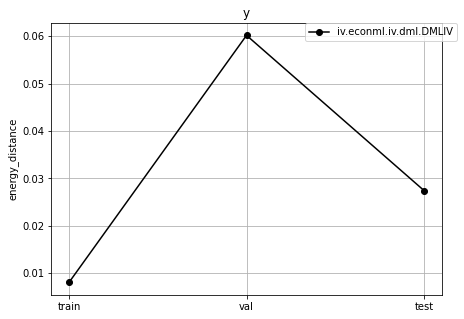

In [72]:
# Compare all estimator performance

%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

colors = ([matplotlib.colors.CSS4_COLORS['black']] +
    list(matplotlib.colors.TABLEAU_COLORS) + [
    matplotlib.colors.CSS4_COLORS['lime'],
    matplotlib.colors.CSS4_COLORS['yellow'],
    matplotlib.colors.CSS4_COLORS['pink']
])


plt.figure(figsize = (7,5))
plt.title(outcome)

m1 = "energy_distance"

for (est, scr), col in zip(ac.scores.items(), colors):
    try:
        sc = [scr["scores"]['train'][m1], scr["scores"]['validation'][m1], scr["scores"]['test'][m1]]
        plt.plot(sc, color=col, marker="o", label=est)
        plt.xticks(np.arange(3), ['train', 'val', 'test'])

    except:
        pass

plt.ylabel(m1)
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.grid()
plt.show()


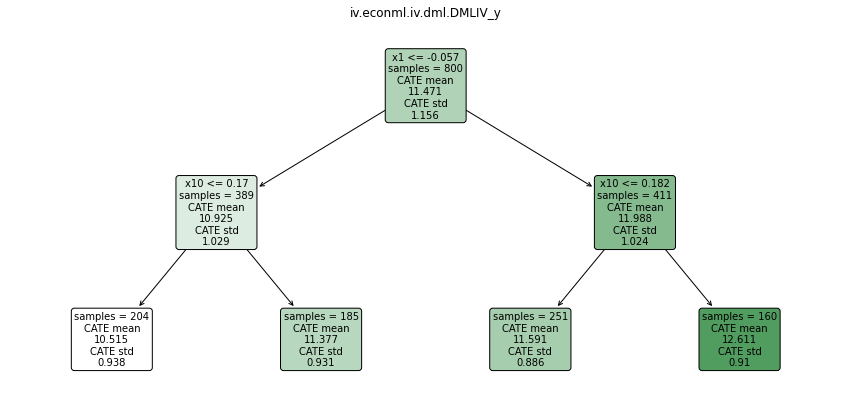

In [73]:
# SingleCATE Tree Interpreter
scr = ac.scores[ac.best_estimator]
intrp = scr["scores"]['validation']['intrp']
plt.figure(figsize=(15, 7))
intrp.plot(feature_names=intrp.feature_names, fontsize=10)
plt.title(f"{ac.best_estimator}_{outcome}")
plt.show()

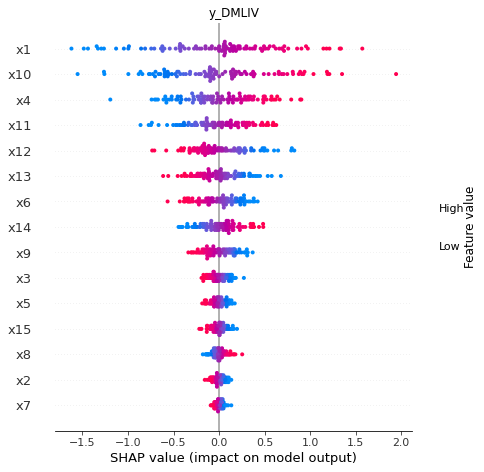

In [70]:
# Feature importance with SHAP explainer
import matplotlib.pyplot as plt
import shap

# and now let's visualize feature importances!
from auto_causality.shap import shap_values

# Shapley values calculation can be slow so let's subsample
this_df = test_df.sample(100)

scr = ac.scores[ac.best_estimator]
est = ac.model
shaps = shap_values(est, this_df)

plt.title(outcome + '_' + ac.best_estimator.split('.')[-1])
shap.summary_plot(shaps, this_df[est.estimator._effect_modifier_names])
plt.show()